### Nutri-score Project - Decision Modeling - Master BDMA 2025/2026

**Notebook 3: Weighted Sum Model**

This notebook implements a Weighted Sum Model to evaluate food products by combining their comprehensive nutritional score (Nutri-Score) with their environmental impact (Green-Score). It aims to provide a single, aggregated index that balances health and sustainability.

**Objectives:**
1. **Define Weights:** Determine appropriate weights for the Nutri-Score and Green-Score components using optimization techniques (maximizing correlation) and feature importance analysis (Random Forest, PCA).
2. **Calculate Scores:** Compute a global score for each product using the linear aggregation method: $S(a) = \sum w_j g_j(a)$.
3. **Define Categories:** Establish thresholds to classify products into 5 categories (A to E) based on their global scores.
4. **Compare Results:** Analyze the consistency between the proposed Weighted Sum classification and the original Nutri-Score labels, as well as the Electre-tri Classifications.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize, differential_evolution
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import model_utils
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# Load and validate database
df = model_utils.load_food_database('data/food_database.xlsx')
model_utils.validate_database(df)

Database loaded: 353 products

=== DATABASE VALIDATION ===
Total products: 353
✓ Database size requirement met

Nutri-Score Distribution:
  ✓ Class A: 71 (20.11%)
  ✓ Class B: 70 (19.83%)
  ✓ Class C: 84 (23.8%)
  ✓ Class D: 59 (16.71%)
  ✓ Class E: 69 (19.55%)

Green-Score Distribution:
  ✓ Class A: 92 (26.06%)
  ✓ Class B: 102 (28.9%)
  ✓ Class C: 56 (15.86%)
  ✓ Class D: 49 (13.88%)
  ✓ Class E: 54 (15.3%)


#### Weighted Sum Model

In [3]:
# Example usage with different weighting schemes:

# Scheme 1: Equal weights
weights_equal = {
    'energy_100g': 0.125,
    'saturated_fat_100g': 0.125,
    'sugars_100g': 0.125,
    'salt_100g': 0.125,
    'proteins_100g': 0.125,
    'fiber_100g': 0.125,
    'fvl_percent': 0.125,
    'green_score_value': 0.125
}

# Scheme 2: Emphasize negative nutrients and environmental impact
weights_emphasis_negative = {
    'energy_100g': 0.15,
    'saturated_fat_100g': 0.15,
    'sugars_100g': 0.15,
    'salt_100g': 0.15,
    'proteins_100g': 0.05,
    'fiber_100g': 0.05,
    'fvl_percent': 0.10,
    'green_score_value': 0.20  # More weight on environmental impact
}

# Scheme 3: Balanced nutrition and environment
weights_balanced = {
    'energy_100g': 0.10,
    'saturated_fat_100g': 0.10,
    'sugars_100g': 0.10,
    'salt_100g': 0.10,
    'proteins_100g': 0.10,
    'fiber_100g': 0.10,
    'fvl_percent': 0.15,
    'green_score_value': 0.25  # Strong emphasis on environment
}

# Scheme 4: Traditional Nutri-Score approach adapted
# Mirrors the point system in Nutri-Score but includes Green-Score
weights_nutriscore_style = {
    'energy_100g': 0.15,      # Max 10 points in N component
    'saturated_fat_100g': 0.15, # Max 10 points in N component
    'sugars_100g': 0.15,       # Max 15 points in N component
    'salt_100g': 0.15,         # Max 20 points in N component
    'proteins_100g': 0.08,     # Max 7 points in P component
    'fiber_100g': 0.07,        # Max 7 points in P component
    'fvl_percent': 0.05,       # Max 5 points in P component
    'green_score_value': 0.20  # Added environmental dimension
}

def normalize_column(series, direction='minimize'):
    """
    Normalize a column to [0, 1] range.
    
    Parameters:
    - series: pandas Series to normalize
    - direction: 'minimize' or 'maximize'
    
    Returns:
    - Normalized series where higher values are better
    """
    min_val = series.min()
    max_val = series.max()
    
    if max_val == min_val:
        return pd.Series(np.ones(len(series)), index=series.index)
    
    if direction == 'minimize':
        # For criteria to minimize: lower is better, so invert
        normalized = (max_val - series) / (max_val - min_val)
    else:  # maximize
        # For criteria to maximize: higher is better
        normalized = (series - min_val) / (max_val - min_val)
    
    return normalized

In [18]:
def normalize_data(df, columns, direction_mapping=None):
    """
    Normalize data for specified columns using min-max scaling with direction awareness.
    
    Args:
        df: Input DataFrame
        columns: List of column names to normalize
        direction_mapping: Dict {column: 'minimize'|'maximize'} or None for defaults
    
    Returns:
        DataFrame with normalized columns (higher values = better)
    """
    df_norm = df.copy()
    
    # Default directions: minimize bad nutrients, maximize good ones
    default_directions = {
        'energy_100g': 'minimize',
        'saturated_fat_100g': 'minimize', 
        'sugars_100g': 'minimize',
        'salt_100g': 'minimize',
        'proteins_100g': 'maximize',
        'fiber_100g': 'maximize',
        'fvl_percent': 'maximize',
        'green_score': 'maximize'
    }
    
    directions = default_directions if direction_mapping is None else direction_mapping
    
    for col in columns:
        if col in df.columns:
            series = df[col]
            min_val = series.min()
            max_val = series.max()
            
            if max_val == min_val:
                df_norm[col] = 1.0
            else:
                direction = directions.get(col, 'maximize')
                if direction == 'minimize':
                    df_norm[col] = (max_val - series) / (max_val - min_val)
                else:
                    df_norm[col] = (series - min_val) / (max_val - min_val)
        else:
            print(f"Warning: Column '{col}' not found in DataFrame")
            df_norm[col] = 0.0
    
    return df_norm

def weighted_sum_confusion_analysis(df, experiment_name, weights=None, thresholds=None):
    """
    Runs a Weighted Sum experiment using the provided weights dictionary.
    
    Args:
        df: DataFrame.
        experiment_name: Title for the output.
        weights: Dictionary {column_name: weight_value}. 
                 Must include all columns you want to score (nutrients + green score).
                 Weights should ideally sum to 1.0.
    """
    # 1. Setup Default Weights if None
    if weights is None:
        nutri_criteria = ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 
                          'proteins_100g', 'fiber_100g', 'fvl_percent']
        weights = {col: 1.0/len(nutri_criteria) for col in nutri_criteria}

    # 2. Normalize Data for all columns present in 'weights'
    relevant_cols = list(weights.keys())
    df_norm = normalize_data(df, relevant_cols)
    
    # 3. Calculate Weighted Score
    scores = np.zeros(len(df))
    for col, w in weights.items():
        if col in df_norm.columns:
            scores += df_norm[col] * w
            
    # 4. Assign Labels
    if thresholds is None:
        thresholds = np.quantile(scores, [0.2, 0.4, 0.6, 0.8])
        
    def get_label(s):
        if s >= thresholds[3]: return 'A'
        elif s >= thresholds[2]: return 'B'
        elif s >= thresholds[1]: return 'C'
        elif s >= thresholds[0]: return 'D'
        else: return 'E'
        
    y_pred = [get_label(s) for s in scores]
    y_true = df['nutri_score_label'].values
    
    # 5. Metrics & Plotting
    accuracy = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=['E','D','C','B','A'])
    
    print(f"\n{'='*80}")
    print(f"EXPERIMENT: {experiment_name}")
    print(f"{'='*80}")
    print(f"Weights Used: {list(weights.keys())}")
    print(f"Overall Accuracy:   {accuracy:.1%} ({int(accuracy*len(df))}/{len(df)})")
    
    # Compute percentages (row-normalized)
    percentages = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    # Dual annotation: count + %
    labels = np.asarray([[f'{c}\n({p:.0f}%)' for c, p in zip(row, perc_row)] 
                        for row, perc_row in zip(cm, percentages)])

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=labels, fmt='', cmap='Greens', 
                xticklabels=['E\'','D\'','C\'','B\'','A\''],
                yticklabels=['E','D','C','B','A'],
                cbar_kws={'label': 'Count'},
                annot_kws={"size": 14, "weight": "bold"})

    plt.title(f'{experiment_name}\nAccuracy: {accuracy:.1%}')
    plt.xlabel('Predicted (Weighted Sum)')
    plt.ylabel('True Nutri-Score')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, 
                               labels=['E','D','C','B','A'], zero_division=0))
    
    # return {'accuracy': accuracy, 'weights': weights}

#### Baseline: Profiles based on Quantiles + Equal Weights (1/8)

In [5]:
weights = {
    'energy_100g': 0.125,
    'saturated_fat_100g': 0.125,
    'sugars_100g': 0.125,
    'salt_100g': 0.125,
    'proteins_100g': 0.125,
    'fiber_100g': 0.125,
    'fvl_percent': 0.125,
    'green_score_value': 0.125
}

#### Trial: Profiles based on Quantiles + Equal Weights (1/8)

In [6]:
# ============================================================================
# METHOD 1: OPTIMIZATION-BASED APPROACH (Learn from Nutri-Score)
# ============================================================================

def optimize_weights_and_thresholds(df, criteria_cols, target_col='nutri_score_label',
                                   method='minimize_error'):
    """
    Learn optimal weights and thresholds by minimizing classification error
    against the original Nutri-Score.
    
    Parameters:
    - df: DataFrame with nutritional data
    - criteria_cols: list of criterion column names
    - target_col: reference classification column
    - method: 'minimize_error' or 'maximize_accuracy'
    
    Returns:
    - optimal_weights: dict with optimized weights
    - optimal_thresholds: list of 4 thresholds
    - optimization_result: details of optimization
    """
    
    # Prepare data
    criteria_config = {
        'energy_100g': 'minimize',
        'saturated_fat_100g': 'minimize', 
        'sugars_100g': 'minimize',
        'salt_100g': 'minimize',
        'proteins_100g': 'maximize',
        'fiber_100g': 'maximize',
        'fvl_percent': 'maximize',
        'green_score_value': 'maximize'
    }
    
    # Normalize data
    X_norm = pd.DataFrame()
    for col in criteria_cols:
        if col in df.columns:
            direction = criteria_config.get(col, 'maximize')
            min_val, max_val = df[col].min(), df[col].max()
            if max_val > min_val:
                if direction == 'minimize':
                    X_norm[col] = (max_val - df[col]) / (max_val - min_val)
                else:
                    X_norm[col] = (df[col] - min_val) / (max_val - min_val)
            else:
                X_norm[col] = 1.0
    
    # Map target classes to numeric
    class_mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
    if "'" in str(df[target_col].iloc[0]):
        y = df[target_col].str.replace("'", "").map(class_mapping)
    else:
        y = df[target_col].str.upper().map(class_mapping)
    
    n_criteria = len(criteria_cols)
    
    def objective_function(params):
        """
        Params: [w1, w2, ..., wn, t1, t2, t3, t4]
        where wi are weights and ti are thresholds
        """
        weights = params[:n_criteria]
        weights = weights / weights.sum()  # Normalize weights
        thresholds = sorted(params[n_criteria:])  # Ensure ordered thresholds
        
        # Calculate weighted sum
        weighted_sum = (X_norm.values * weights).sum(axis=1)
        
        # Classify
        predictions = np.zeros(len(weighted_sum), dtype=int)
        predictions[weighted_sum <= thresholds[0]] = 4  # E
        predictions[(weighted_sum > thresholds[0]) & (weighted_sum <= thresholds[1])] = 3  # D
        predictions[(weighted_sum > thresholds[1]) & (weighted_sum <= thresholds[2])] = 2  # C
        predictions[(weighted_sum > thresholds[2]) & (weighted_sum <= thresholds[3])] = 1  # B
        predictions[weighted_sum > thresholds[3]] = 0  # A
        
        # Calculate error (misclassification rate + penalty for class imbalance)
        error = (predictions != y).sum() / len(y)
        
        # Add penalty for extreme threshold spacing
        threshold_spacing = np.diff(thresholds)
        spacing_penalty = 0.01 * np.sum(np.maximum(0, 0.05 - threshold_spacing))
        
        return error + spacing_penalty
    
    # Initial guess: equal weights, quintile thresholds
    initial_weights = np.ones(n_criteria) / n_criteria
    weighted_sum_init = (X_norm.values * initial_weights).sum(axis=1)
    initial_thresholds = [
        np.quantile(weighted_sum_init, 0.2),
        np.quantile(weighted_sum_init, 0.4),
        np.quantile(weighted_sum_init, 0.6),
        np.quantile(weighted_sum_init, 0.8)
    ]
    initial_params = np.concatenate([initial_weights, initial_thresholds])
    
    # Bounds: weights [0, 1], thresholds [0, 1]
    bounds = [(0.01, 1.0)] * n_criteria + [(0.0, 1.0)] * 4
    
    # Optimize using differential evolution (global optimization)
    print("Optimizing weights and thresholds...")
    result = differential_evolution(
        objective_function,
        bounds=bounds,
        seed=42,
        maxiter=500,
        popsize=15,
        tol=1e-6,
        workers=1
    )
    
    # Extract optimal parameters
    optimal_weights_array = result.x[:n_criteria]
    optimal_weights_array = optimal_weights_array / optimal_weights_array.sum()
    weights_optimal = dict(zip(criteria_cols, optimal_weights_array))
    thresholds_optimal = sorted(result.x[n_criteria:])
    
    print(f"✓ Optimization complete!")
    print(f"  Final error rate: {result.fun:.4f}")
    print(f"  Accuracy: {1 - result.fun:.4f}")
    
    return weights_optimal, thresholds_optimal, result

In [7]:
# ============================================================================
# METHOD 2: RANDOM FOREST FEATURE IMPORTANCE
# ============================================================================

def get_weights_from_feature_importance(df, criteria_cols, target_col='nutriscore_grade',
                                       n_estimators=200):
    """
    Use Random Forest feature importance to determine criterion weights.
    
    Returns:
    - weights: dict with weights based on feature importance
    - model: trained Random Forest model
    - feature_importance_df: DataFrame with detailed importance scores
    """
    
    # Prepare data
    X = df[criteria_cols].copy()
    
    # Handle missing values
    X = X.fillna(X.median())
    
    # Prepare target
    if "'" in str(df[target_col].iloc[0]):
        y = df[target_col].str.replace("'", "")
    else:
        y = df[target_col].str.upper()
    
    # Train Random Forest
    print(f"Training Random Forest with {n_estimators} trees...")
    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=10, 
                                random_state=42, n_jobs=-1)
    rf.fit(X, y)
    
    # Get feature importance
    importance = rf.feature_importances_
    
    # Normalize to sum to 1
    weights_array = importance / importance.sum()
    weights_rf = dict(zip(criteria_cols, weights_array))
    
    # Cross-validation score
    cv_scores = cross_val_score(rf, X, y, cv=5)
    
    # Create detailed report
    importance_df = pd.DataFrame({
        'Criterion': criteria_cols,
        'Importance': importance,
        'Weight': weights_array,
        'Weight %': weights_array * 100
    }).sort_values('Importance', ascending=False)
    
    print(f"✓ Random Forest trained!")
    print(f"  CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    print(f"\nFeature Importance Ranking:")
    print(importance_df.to_string(index=False))
    
    return weights_rf, rf, importance_df

In [8]:
# ============================================================================
# METHOD 3: PRINCIPAL COMPONENT ANALYSIS (PCA)
# ============================================================================

def get_weights_from_pca(df, criteria_cols, n_components=1):
    """
    Use PCA to derive weights based on variance explained.
    The first principal component captures the most variance.
    
    Returns:
    - weights: dict with PCA-derived weights
    - pca: fitted PCA object
    - explained_variance_ratio: variance explained by each component
    """
    from sklearn.decomposition import PCA
    
    # Prepare and standardize data
    X = df[criteria_cols].copy().fillna(df[criteria_cols].median())
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Apply PCA
    pca = PCA(n_components=n_components)
    pca.fit(X_scaled)
    
    # Get loadings (weights) from first component
    loadings = np.abs(pca.components_[0])  # Take absolute values
    weights_array = loadings / loadings.sum()  # Normalize
    weights_pca = dict(zip(criteria_cols, weights_array))
    
    print(f"✓ PCA Analysis complete!")
    print(f"  Variance explained by PC1: {pca.explained_variance_ratio_[0]:.4f}")
    print(f"\nPCA-derived weights:")
    for criterion, weight in sorted(weights_pca.items(), key=lambda x: x[1], reverse=True):
        print(f"  {criterion}: {weight:.4f} ({weight*100:.1f}%)")
    
    return weights_pca, pca, pca.explained_variance_ratio_

In [9]:
# ============================================================================
# METHOD 4: CORRELATION-BASED WEIGHTS
# ============================================================================

def get_weights_from_correlation(df, criteria_cols, target_col='nutriscore_grade'):
    """
    Derive weights based on correlation with target classification.
    Stronger correlations get higher weights.
    
    Returns:
    - weights: dict with correlation-based weights
    - correlations: Series with correlation values
    """
    
    # Prepare data
    X = df[criteria_cols].copy().fillna(df[criteria_cols].median())
    
    # Convert target to numeric
    class_mapping = {'A': 5, 'B': 4, 'C': 3, 'D': 2, 'E': 1}
    if "'" in str(df[target_col].iloc[0]):
        y_numeric = df[target_col].str.replace("'", "").map(class_mapping)
    else:
        y_numeric = df[target_col].str.upper().map(class_mapping)
    
    # Calculate absolute correlations
    correlations = X.corrwith(y_numeric).abs()
    
    # Normalize to get weights
    weights_array = correlations / correlations.sum()
    weights_correlation = dict(zip(criteria_cols, weights_array))
    
    print(f"✓ Correlation analysis complete!")
    print(f"\nCorrelation-based weights:")
    for criterion, weight in sorted(weights_correlation.items(), key=lambda x: x[1], reverse=True):
        corr = correlations[criterion]
        print(f"  {criterion}: {weight:.4f} ({weight*100:.1f}%) - corr: {corr:.3f}")
    
    return weights_correlation, correlations

In [10]:
# ============================================================================
# METHOD 5: STATISTICAL THRESHOLDS (QUANTILES, K-MEANS, GMM)
# ============================================================================

def get_statistical_thresholds(df, weights, method='quantile', target=None):
    """
    Determine thresholds using statistical methods.
    
    Parameters:
    - weighted_sum: array of weighted sum scores
    - method: 'quantile', 'kmeans', 'gmm', or 'jenks'
    - target: optional target classifications for supervised methods
    
    Returns:
    - thresholds: list of 4 threshold values
    """

    criteria_config = {
        'energy_100g': 'minimize',
        'saturated_fat_100g': 'minimize', 
        'sugars_100g': 'minimize',
        'salt_100g': 'minimize',
        'proteins_100g': 'maximize',
        'fiber_100g': 'maximize',
        'fvl_percent': 'maximize',
        'green_score_value': 'maximize'
    }

    # Normalize data
    X_norm = pd.DataFrame()
    for col in criteria_cols:
        if col in df.columns:
            direction = criteria_config.get(col, 'maximize')
            min_val, max_val = df[col].min(), df[col].max()
            if max_val > min_val:
                if direction == 'minimize':
                    X_norm[col] = (max_val - df[col]) / (max_val - min_val)
                else:
                    X_norm[col] = (df[col] - min_val) / (max_val - min_val)
            else:
                X_norm[col] = 1.0

    # Calculate weighted sum
    weights_array = np.array([weights[col] for col in criteria_cols])
    weighted_sum = (X_norm.values * weights_array).sum(axis=1)

    if method == 'quantile':
        # Simple quantile-based thresholds
        thresholds = [
            np.quantile(weighted_sum, 0.2),
            np.quantile(weighted_sum, 0.4),
            np.quantile(weighted_sum, 0.6),
            np.quantile(weighted_sum, 0.8)
        ]
        print(f"✓ Quantile-based thresholds: {[f'{t:.3f}' for t in thresholds]}")
    
    elif method == 'kmeans':
        # K-means clustering (5 clusters)
        from sklearn.cluster import KMeans
        
        kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
        kmeans.fit(weighted_sum.reshape(-1, 1))
        
        # Get cluster centers and sort them
        centers = sorted(kmeans.cluster_centers_.flatten())
        
        # Thresholds are midpoints between centers
        thresholds = [(centers[i] + centers[i+1]) / 2 for i in range(4)]
        print(f"✓ K-means based thresholds: {[f'{t:.3f}' for t in thresholds]}")
    
    elif method == 'gmm':
        # Gaussian Mixture Model
        from sklearn.mixture import GaussianMixture
        
        gmm = GaussianMixture(n_components=5, random_state=42, n_init=10)
        gmm.fit(weighted_sum.reshape(-1, 1))
        
        # Get means and sort them
        means = sorted(gmm.means_.flatten())
        
        # Thresholds are midpoints between means
        thresholds = [(means[i] + means[i+1]) / 2 for i in range(4)]
        print(f"✓ GMM-based thresholds: {[f'{t:.3f}' for t in thresholds]}")
    
    elif method == 'jenks':
        # Jenks Natural Breaks (requires jenkspy)
        try:
            import jenkspy
            breaks = jenkspy.jenks_breaks(weighted_sum, n_classes=5)
            thresholds = breaks[1:-1]  # Exclude min and max
            print(f"✓ Jenks Natural Breaks thresholds: {[f'{t:.3f}' for t in thresholds]}")
        except ImportError:
            print("⚠ jenkspy not installed. Install with: pip install jenkspy")
            print("  Falling back to quantile method...")
            return get_statistical_thresholds(weighted_sum, method='quantile')
    
    else:
        raise ValueError(f"Unknown method: {method}")
    
    return thresholds


In [11]:
# ============================================================================
# METHOD 6: COMPLETE OPTIMIZATION PIPELINE
# ============================================================================

def compare_all_methods(df, criteria_cols, target_col='nutri_score_label'):
    """
    Compare all statistical methods for determining weights and thresholds.
    
    Returns:
    - results_summary: DataFrame comparing all methods
    - all_weights: dict with weights from each method
    - all_thresholds: dict with thresholds from each method
    """
    
    print("="*80)
    print("COMPARING ALL STATISTICAL METHODS")
    print("="*80)
    
    all_weights = {}
    all_results = []
    
    # Method 1: Optimization
    print("\n" + "-"*80)
    print("METHOD 1: Optimization-based (Learning from Nutri-Score)")
    print("-"*80)
    opt_weights, opt_thresholds, opt_result = optimize_weights_and_thresholds(
        df, criteria_cols, target_col
    )
    all_weights['Optimization'] = opt_weights
    all_results.append({
        'Method': 'Optimization',
        'Accuracy': 1 - opt_result.fun,
        'Error Rate': opt_result.fun
    })
    
    # Method 2: Random Forest
    print("\n" + "-"*80)
    print("METHOD 2: Random Forest Feature Importance")
    print("-"*80)
    rf_weights, rf_model, rf_importance = get_weights_from_feature_importance(
        df, criteria_cols, target_col
    )
    all_weights['Random Forest'] = rf_weights
    cv_scores = cross_val_score(rf_model, df[criteria_cols].fillna(df[criteria_cols].median()), 
                                df[target_col].str.upper().str.replace("'", ""), cv=5)
    all_results.append({
        'Method': 'Random Forest',
        'Accuracy': cv_scores.mean(),
        'Error Rate': 1 - cv_scores.mean()
    })
    
    # Method 3: PCA
    print("\n" + "-"*80)
    print("METHOD 3: Principal Component Analysis")
    print("-"*80)
    pca_weights, pca_model, pca_var = get_weights_from_pca(df, criteria_cols)
    all_weights['PCA'] = pca_weights
    
    # Method 4: Correlation
    print("\n" + "-"*80)
    print("METHOD 4: Correlation-based")
    print("-"*80)
    corr_weights, correlations = get_weights_from_correlation(df, criteria_cols, target_col)
    all_weights['Correlation'] = corr_weights
    
    # Create comparison DataFrame
    comparison_df = pd.DataFrame(all_weights).T
    comparison_df['Sum'] = comparison_df.sum(axis=1)
    
    print("\n" + "="*80)
    print("WEIGHT COMPARISON ACROSS ALL METHODS")
    print("="*80)
    print(comparison_df)
    
    results_df = pd.DataFrame(all_results)
    print("\n" + "="*80)
    print("ACCURACY COMPARISON")
    print("="*80)
    print(results_df.to_string(index=False))
    
    return results_df, all_weights, opt_thresholds


# ============================================================================
# EXAMPLE USAGE
# ============================================================================

criteria_cols = ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 
                 'salt_100g', 'proteins_100g', 'fiber_100g', 
                 'fvl_percent', 'green_score_value']

# Compare all methods
results, all_weights, thresholds = compare_all_methods(
    df, criteria_cols, 'nutri_score_label'
)


COMPARING ALL STATISTICAL METHODS

--------------------------------------------------------------------------------
METHOD 1: Optimization-based (Learning from Nutri-Score)
--------------------------------------------------------------------------------
Optimizing weights and thresholds...
✓ Optimization complete!
  Final error rate: 0.2074
  Accuracy: 0.7926

--------------------------------------------------------------------------------
METHOD 2: Random Forest Feature Importance
--------------------------------------------------------------------------------
Training Random Forest with 200 trees...
✓ Random Forest trained!
  CV Accuracy: 0.5663 (+/- 0.1024)

Feature Importance Ranking:
         Criterion  Importance   Weight  Weight %
         salt_100g    0.170357 0.170357 17.035727
       sugars_100g    0.164154 0.164154 16.415438
       energy_100g    0.149664 0.149664 14.966379
saturated_fat_100g    0.136880 0.136880 13.688010
     proteins_100g    0.113533 0.113533 11.353349
  

In [12]:
weights_optimal, thresholds_optimal, optimization_result = optimize_weights_and_thresholds(
    df, criteria_cols, target_col='nutri_score_label'
)

Optimizing weights and thresholds...
✓ Optimization complete!
  Final error rate: 0.2074
  Accuracy: 0.7926


### OPTIMIZED WEIGHTS AND THRESHOLDS

In [13]:
thresholds_optimal

[np.float64(0.730570602016196),
 np.float64(0.7889607899489098),
 np.float64(0.8136267461413131),
 np.float64(0.8304929697625452)]

In [14]:
weights_optimal

{'energy_100g': np.float64(0.06848415607702134),
 'saturated_fat_100g': np.float64(0.2128588362840498),
 'sugars_100g': np.float64(0.13824387475254973),
 'salt_100g': np.float64(0.4088220911907629),
 'proteins_100g': np.float64(0.07575266482185546),
 'fiber_100g': np.float64(0.07102152798817198),
 'fvl_percent': np.float64(0.017393587050708943),
 'green_score_value': np.float64(0.007423261834879819)}


EXPERIMENT: Optimal Weights, Optimal Thresholds
Weights Used: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']
Overall Accuracy:   79.3% (280/353)


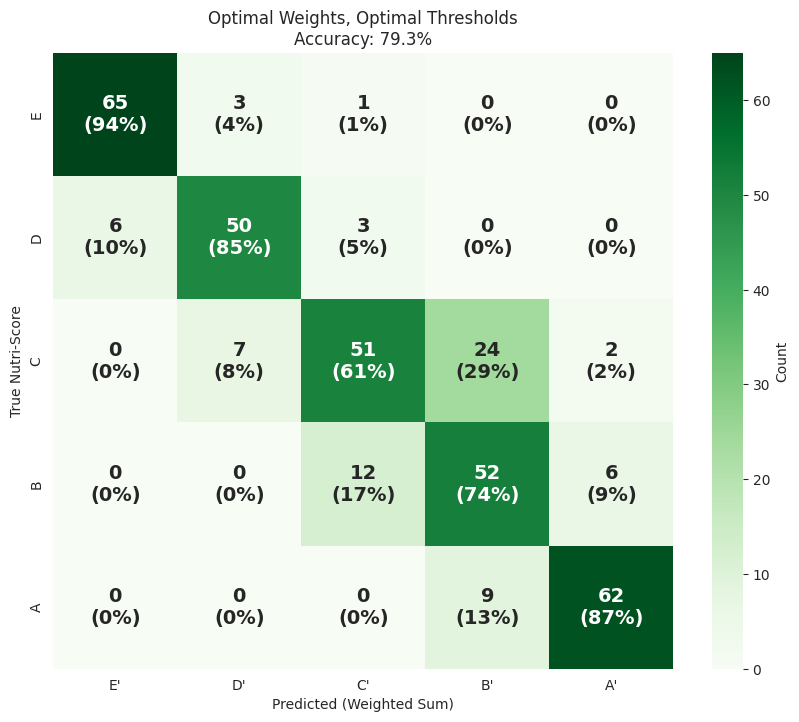


Classification Report:
              precision    recall  f1-score   support

           E       0.92      0.94      0.93        69
           D       0.83      0.85      0.84        59
           C       0.76      0.61      0.68        84
           B       0.61      0.74      0.67        70
           A       0.89      0.87      0.88        71

    accuracy                           0.79       353
   macro avg       0.80      0.80      0.80       353
weighted avg       0.80      0.79      0.79       353



In [15]:
weighted_sum_confusion_analysis(
    df, 
    experiment_name="Optimal Weights, Optimal Thresholds",
    weights=weights_optimal,
    thresholds=thresholds_optimal)

### RF WEIGHTS

✓ K-means based thresholds: ['0.475', '0.573', '0.645', '0.706']

EXPERIMENT: RF Weights, Kmeans Thresholds
Weights Used: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']
Overall Accuracy:   41.1% (145/353)


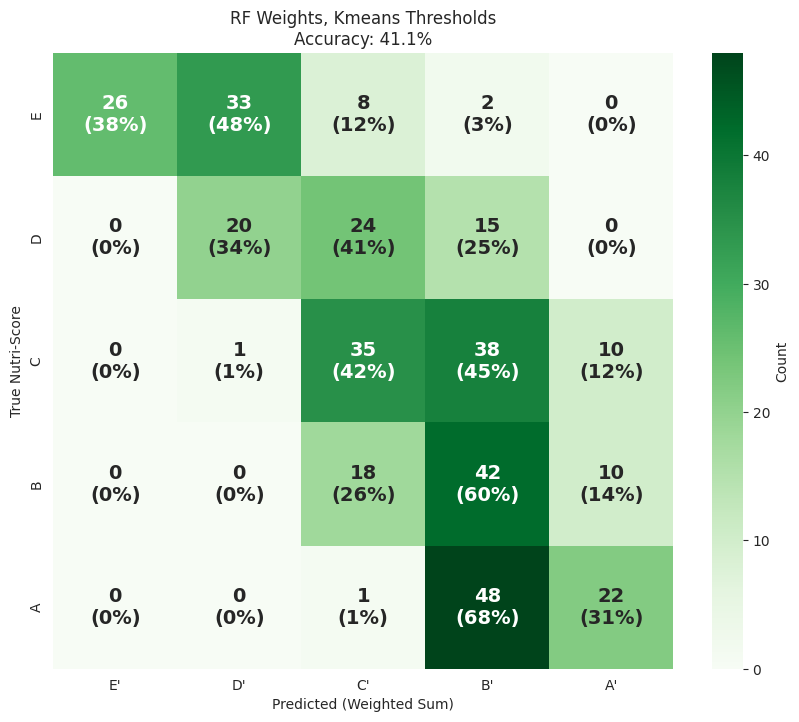


Classification Report:
              precision    recall  f1-score   support

           E       1.00      0.38      0.55        69
           D       0.37      0.34      0.35        59
           C       0.41      0.42      0.41        84
           B       0.29      0.60      0.39        70
           A       0.52      0.31      0.39        71

    accuracy                           0.41       353
   macro avg       0.52      0.41      0.42       353
weighted avg       0.52      0.41      0.42       353



In [20]:
weighted_sum_confusion_analysis(
    df, 
    experiment_name="RF Weights, Kmeans Thresholds",
    weights=all_weights['Random Forest'],
    thresholds=get_statistical_thresholds(
        df, all_weights['Random Forest'],
        method='kmeans'))

✓ Quantile-based thresholds: ['0.558', '0.636', '0.661', '0.691']

EXPERIMENT: RF Weights, Quantile Thresholds
Weights Used: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']
Overall Accuracy:   45.0% (159/353)


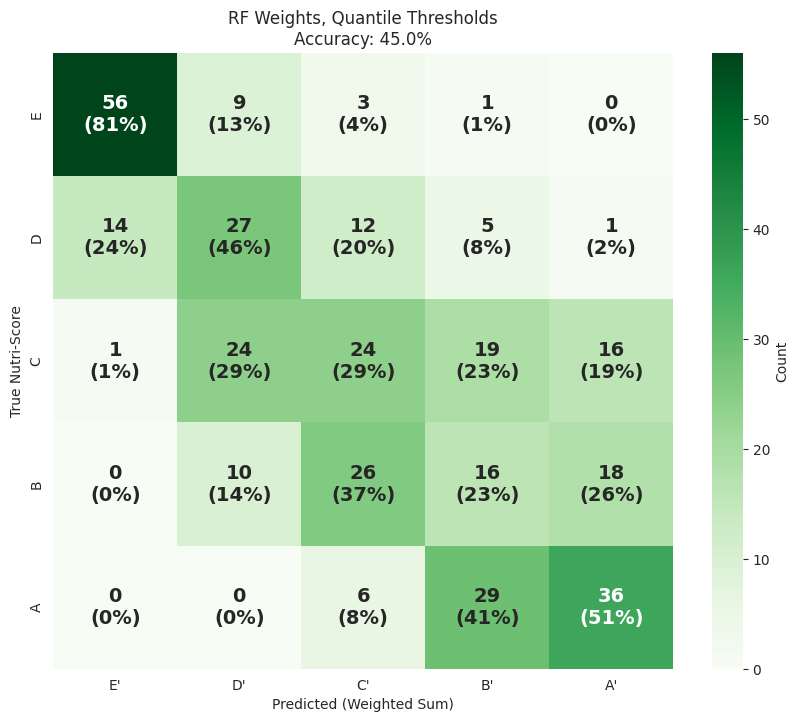


Classification Report:
              precision    recall  f1-score   support

           E       0.79      0.81      0.80        69
           D       0.39      0.46      0.42        59
           C       0.34      0.29      0.31        84
           B       0.23      0.23      0.23        70
           A       0.51      0.51      0.51        71

    accuracy                           0.45       353
   macro avg       0.45      0.46      0.45       353
weighted avg       0.45      0.45      0.45       353



In [21]:
weighted_sum_confusion_analysis(
    df, 
    experiment_name="RF Weights, Quantile Thresholds",
    weights=all_weights['Random Forest'],
    thresholds=get_statistical_thresholds(
        df, all_weights['Random Forest'],
        method='quantile'))

✓ GMM-based thresholds: ['0.479', '0.579', '0.649', '0.707']

EXPERIMENT: RF Weights, GMM Thresholds
Weights Used: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']
Overall Accuracy:   40.2% (142/353)


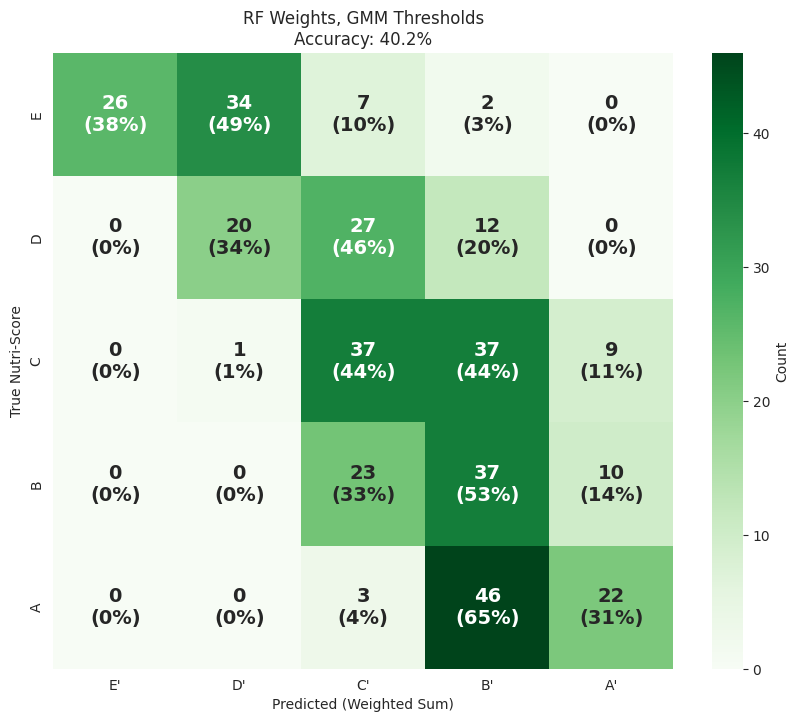


Classification Report:
              precision    recall  f1-score   support

           E       1.00      0.38      0.55        69
           D       0.36      0.34      0.35        59
           C       0.38      0.44      0.41        84
           B       0.28      0.53      0.36        70
           A       0.54      0.31      0.39        71

    accuracy                           0.40       353
   macro avg       0.51      0.40      0.41       353
weighted avg       0.51      0.40      0.41       353



In [23]:
weighted_sum_confusion_analysis(
    df, 
    experiment_name="RF Weights, GMM Thresholds",
    weights=all_weights['Random Forest'],
    thresholds=get_statistical_thresholds(
        df, all_weights['Random Forest'],
        method='gmm'))

✓ Jenks Natural Breaks thresholds: ['0.471', '0.568', '0.645', '0.702']

EXPERIMENT: RF Weights, Jenks Thresholds
Weights Used: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']
Overall Accuracy:   41.1% (145/353)


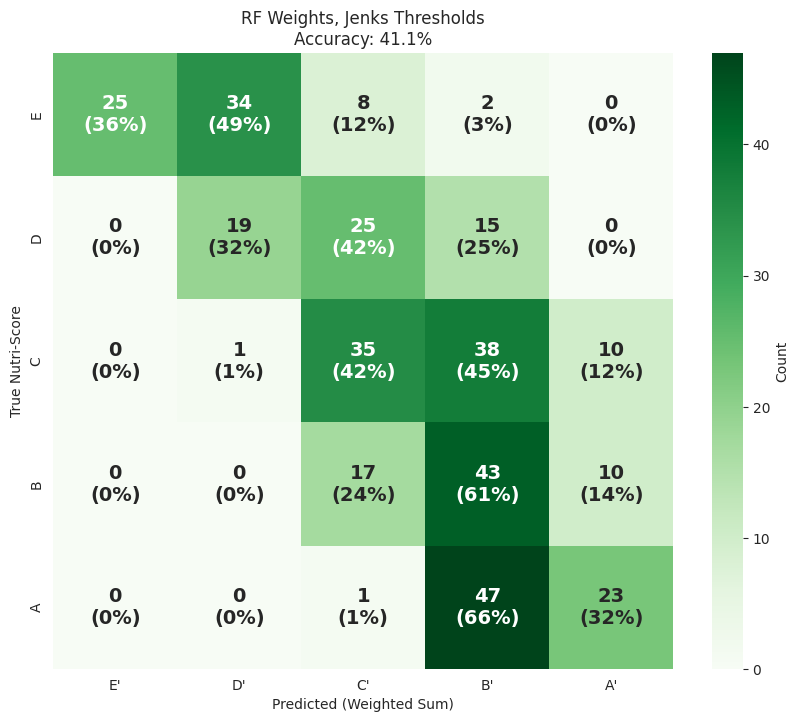


Classification Report:
              precision    recall  f1-score   support

           E       1.00      0.36      0.53        69
           D       0.35      0.32      0.34        59
           C       0.41      0.42      0.41        84
           B       0.30      0.61      0.40        70
           A       0.53      0.32      0.40        71

    accuracy                           0.41       353
   macro avg       0.52      0.41      0.42       353
weighted avg       0.52      0.41      0.42       353



In [24]:
weighted_sum_confusion_analysis(
    df, 
    experiment_name="RF Weights, Jenks Thresholds",
    weights=all_weights['Random Forest'],
    thresholds=get_statistical_thresholds(
        df, all_weights['Random Forest'],
        method='jenks'))


EXPERIMENT: RF Weights, Equal Thresholds
Weights Used: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']
Overall Accuracy:   21.2% (75/353)


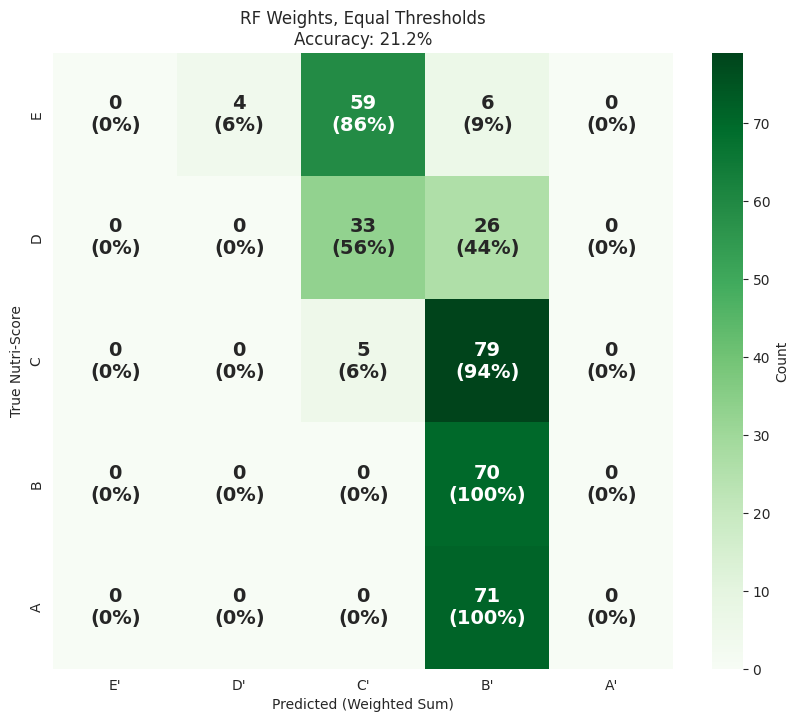


Classification Report:
              precision    recall  f1-score   support

           E       0.00      0.00      0.00        69
           D       0.00      0.00      0.00        59
           C       0.05      0.06      0.06        84
           B       0.28      1.00      0.43        70
           A       0.00      0.00      0.00        71

    accuracy                           0.21       353
   macro avg       0.07      0.21      0.10       353
weighted avg       0.07      0.21      0.10       353



In [25]:
weighted_sum_confusion_analysis(
    df, 
    experiment_name="RF Weights, Equal Thresholds",
    weights=all_weights['Random Forest'],
    thresholds=[0.2, 0.4, 0.6, 0.8])

### PCA WEIGHTS


EXPERIMENT: PCA Weights, Equal Thresholds
Weights Used: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']
Overall Accuracy:   26.3% (93/353)


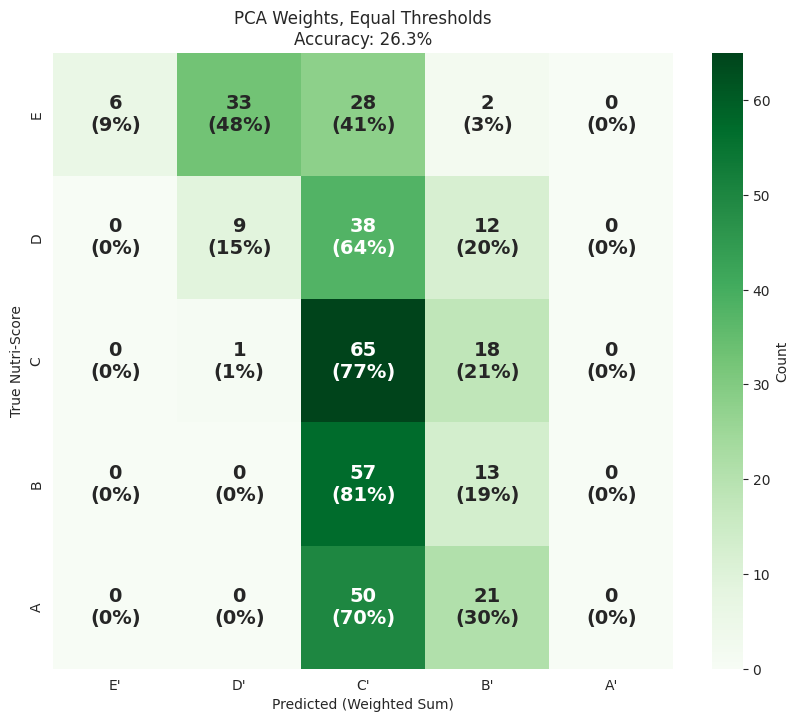


Classification Report:
              precision    recall  f1-score   support

           E       1.00      0.09      0.16        69
           D       0.21      0.15      0.18        59
           C       0.27      0.77      0.40        84
           B       0.20      0.19      0.19        70
           A       0.00      0.00      0.00        71

    accuracy                           0.26       353
   macro avg       0.34      0.24      0.19       353
weighted avg       0.33      0.26      0.19       353



In [41]:
weighted_sum_confusion_analysis(
    df, 
    experiment_name="PCA Weights, Equal Thresholds",
    weights=all_weights['PCA'],
    thresholds=[0.2, 0.4, 0.6, 0.8])

✓ Quantile-based thresholds: ['0.442', '0.501', '0.534', '0.586']

EXPERIMENT: PCA Weights, Quantile Thresholds
Weights Used: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']
Overall Accuracy:   33.1% (117/353)


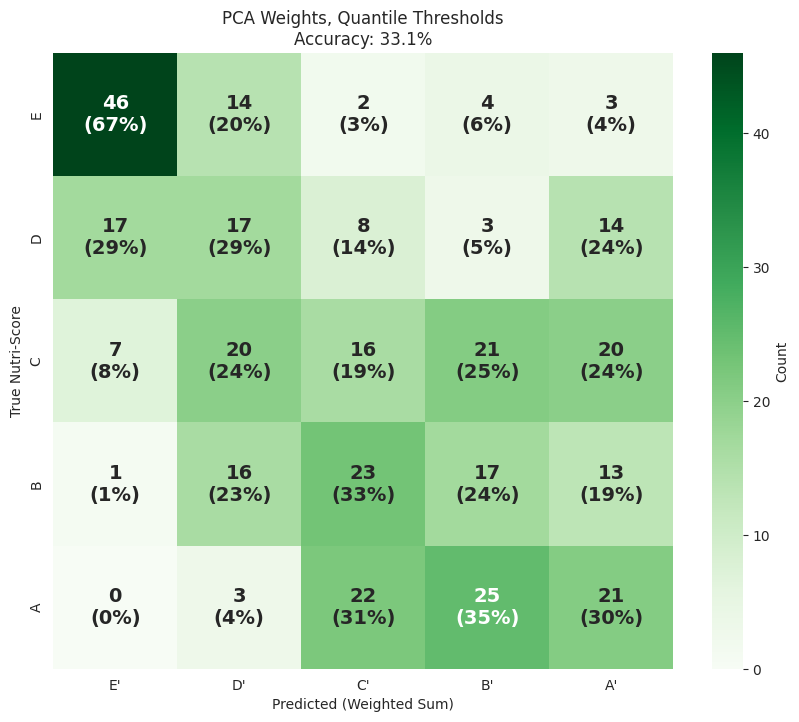


Classification Report:
              precision    recall  f1-score   support

           E       0.65      0.67      0.66        69
           D       0.24      0.29      0.26        59
           C       0.23      0.19      0.21        84
           B       0.24      0.24      0.24        70
           A       0.30      0.30      0.30        71

    accuracy                           0.33       353
   macro avg       0.33      0.34      0.33       353
weighted avg       0.33      0.33      0.33       353



In [26]:
weighted_sum_confusion_analysis(
    df, 
    experiment_name="PCA Weights, Quantile Thresholds",
    weights=all_weights['PCA'],
    thresholds=get_statistical_thresholds(
        df, all_weights['PCA'],
        method='quantile'))

✓ K-means based thresholds: ['0.325', '0.452', '0.532', '0.627']

EXPERIMENT: PCA Weights, Kmeans Thresholds
Weights Used: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']
Overall Accuracy:   31.2% (110/353)


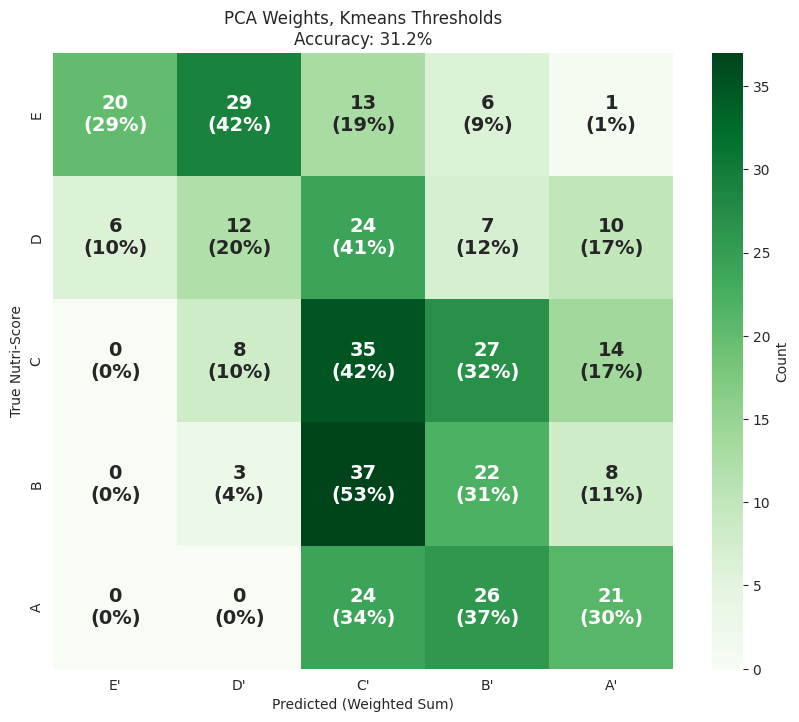


Classification Report:
              precision    recall  f1-score   support

           E       0.77      0.29      0.42        69
           D       0.23      0.20      0.22        59
           C       0.26      0.42      0.32        84
           B       0.25      0.31      0.28        70
           A       0.39      0.30      0.34        71

    accuracy                           0.31       353
   macro avg       0.38      0.30      0.31       353
weighted avg       0.38      0.31      0.32       353



In [27]:
weighted_sum_confusion_analysis(
    df, 
    experiment_name="PCA Weights, Kmeans Thresholds",
    weights=all_weights['PCA'],
    thresholds=get_statistical_thresholds(
        df, all_weights['PCA'],
        method='kmeans'))

✓ GMM-based thresholds: ['0.346', '0.481', '0.589', '0.711']

EXPERIMENT: PCA Weights, GMM Thresholds
Weights Used: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']
Overall Accuracy:   33.1% (117/353)


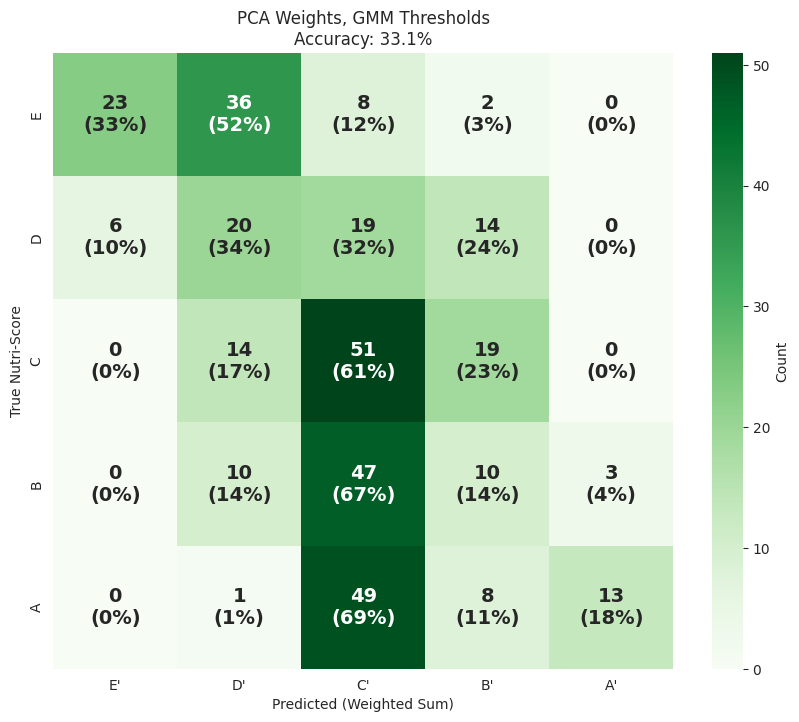


Classification Report:
              precision    recall  f1-score   support

           E       0.79      0.33      0.47        69
           D       0.25      0.34      0.29        59
           C       0.29      0.61      0.40        84
           B       0.19      0.14      0.16        70
           A       0.81      0.18      0.30        71

    accuracy                           0.33       353
   macro avg       0.47      0.32      0.32       353
weighted avg       0.47      0.33      0.33       353



In [28]:
weighted_sum_confusion_analysis(
    df, 
    experiment_name="PCA Weights, GMM Thresholds",
    weights=all_weights['PCA'],
    thresholds=get_statistical_thresholds(
        df, all_weights['PCA'],
        method='gmm'))

✓ Jenks Natural Breaks thresholds: ['0.316', '0.450', '0.531', '0.627']

EXPERIMENT: PCA Weights, Jenks Thresholds
Weights Used: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']
Overall Accuracy:   31.2% (110/353)


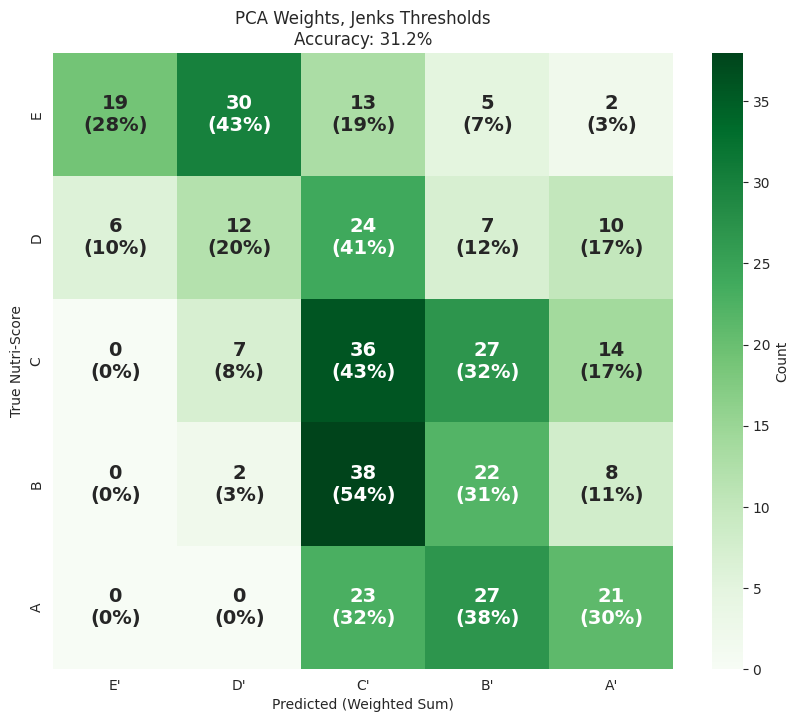


Classification Report:
              precision    recall  f1-score   support

           E       0.76      0.28      0.40        69
           D       0.24      0.20      0.22        59
           C       0.27      0.43      0.33        84
           B       0.25      0.31      0.28        70
           A       0.38      0.30      0.33        71

    accuracy                           0.31       353
   macro avg       0.38      0.30      0.31       353
weighted avg       0.38      0.31      0.32       353



In [29]:
weighted_sum_confusion_analysis(
    df, 
    experiment_name="PCA Weights, Jenks Thresholds",
    weights=all_weights['PCA'],
    thresholds=get_statistical_thresholds(
        df, all_weights['PCA'],
        method='jenks'))

### CORRELATION WEIGHTS


EXPERIMENT: Correlation Weights, Equal Thresholds
Weights Used: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']
Overall Accuracy:   21.8% (77/353)


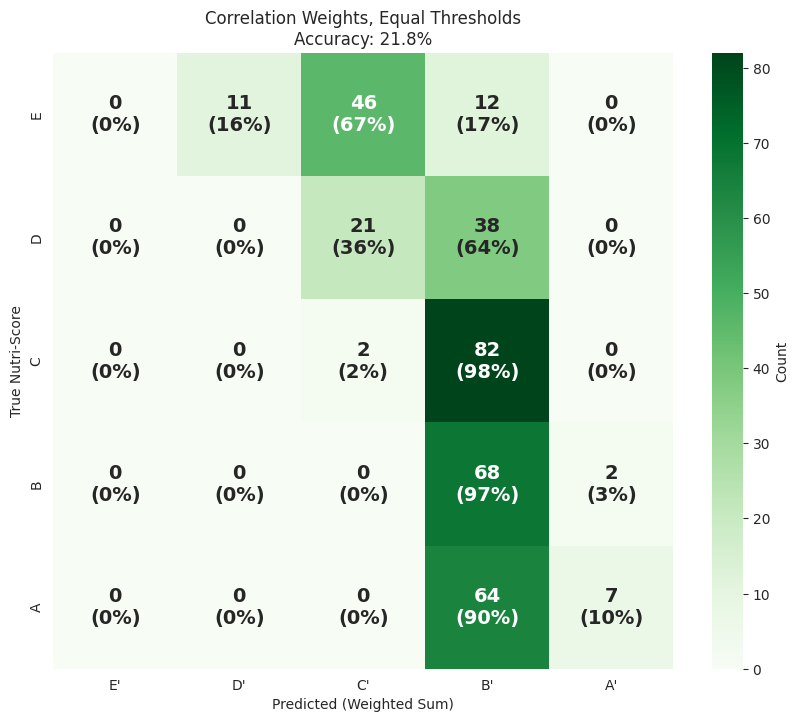


Classification Report:
              precision    recall  f1-score   support

           E       0.00      0.00      0.00        69
           D       0.00      0.00      0.00        59
           C       0.03      0.02      0.03        84
           B       0.26      0.97      0.41        70
           A       0.78      0.10      0.17        71

    accuracy                           0.22       353
   macro avg       0.21      0.22      0.12       353
weighted avg       0.21      0.22      0.12       353



In [42]:
weighted_sum_confusion_analysis(
    df, 
    experiment_name="Correlation Weights, Equal Thresholds",
    weights=all_weights['Correlation'],
    thresholds=[0.2, 0.4, 0.6, 0.8])

✓ Quantile-based thresholds: ['0.580', '0.668', '0.698', '0.724']

EXPERIMENT: Correlation Weights, Quantile Thresholds
Weights Used: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']
Overall Accuracy:   43.6% (154/353)


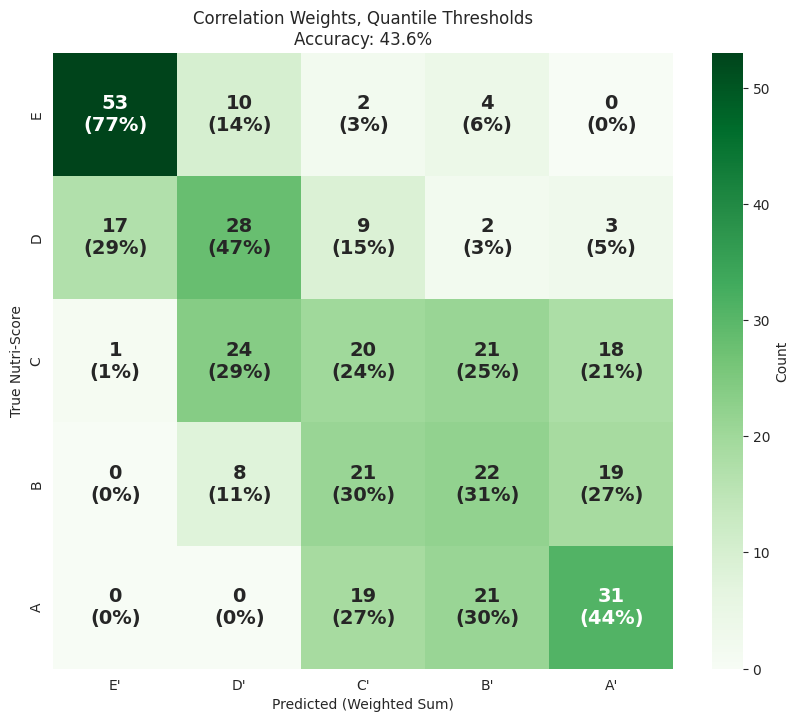


Classification Report:
              precision    recall  f1-score   support

           E       0.75      0.77      0.76        69
           D       0.40      0.47      0.43        59
           C       0.28      0.24      0.26        84
           B       0.31      0.31      0.31        70
           A       0.44      0.44      0.44        71

    accuracy                           0.44       353
   macro avg       0.44      0.45      0.44       353
weighted avg       0.43      0.44      0.43       353



In [31]:
weighted_sum_confusion_analysis(
    df, 
    experiment_name="Correlation Weights, Quantile Thresholds",
    weights=all_weights['Correlation'],
    thresholds=get_statistical_thresholds(
        df, all_weights['Correlation'],
        method='quantile'))

✓ K-means based thresholds: ['0.467', '0.572', '0.659', '0.736']

EXPERIMENT: Correlation Weights, Kmeans Thresholds
Weights Used: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']
Overall Accuracy:   38.2% (135/353)


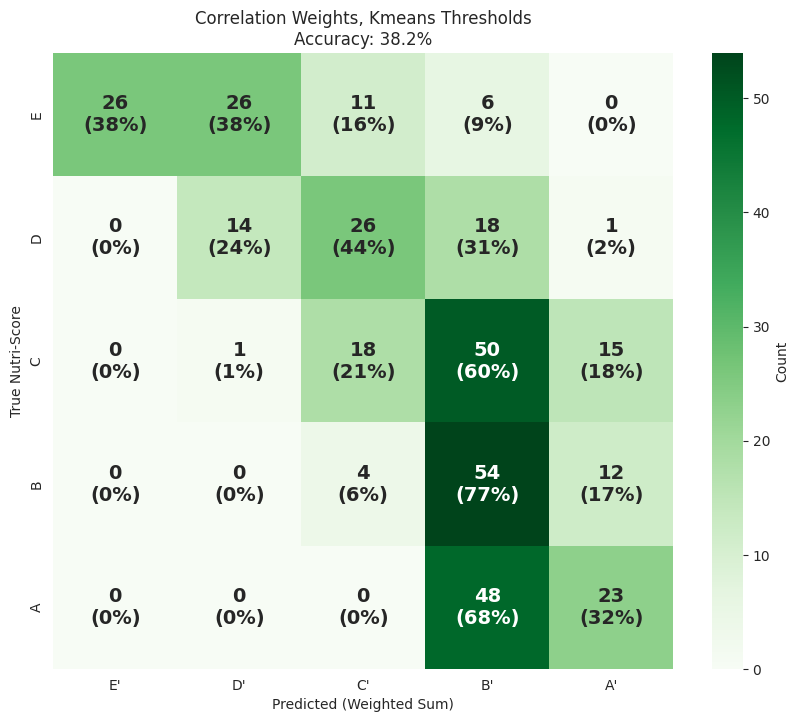


Classification Report:
              precision    recall  f1-score   support

           E       1.00      0.38      0.55        69
           D       0.34      0.24      0.28        59
           C       0.31      0.21      0.25        84
           B       0.31      0.77      0.44        70
           A       0.45      0.32      0.38        71

    accuracy                           0.38       353
   macro avg       0.48      0.38      0.38       353
weighted avg       0.48      0.38      0.38       353



In [32]:
weighted_sum_confusion_analysis(
    df, 
    experiment_name="Correlation Weights, Kmeans Thresholds",
    weights=all_weights['Correlation'],
    thresholds=get_statistical_thresholds(
        df, all_weights['Correlation'],
        method='kmeans'))

✓ GMM-based thresholds: ['0.479', '0.590', '0.671', '0.740']

EXPERIMENT: Correlation Weights, GMM Thresholds
Weights Used: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']
Overall Accuracy:   40.5% (143/353)


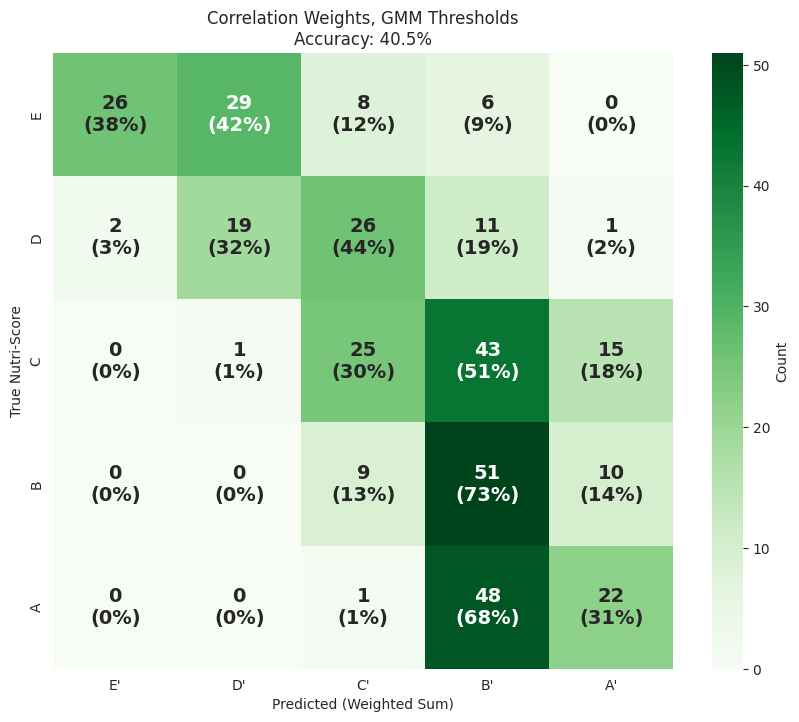


Classification Report:
              precision    recall  f1-score   support

           E       0.93      0.38      0.54        69
           D       0.39      0.32      0.35        59
           C       0.36      0.30      0.33        84
           B       0.32      0.73      0.45        70
           A       0.46      0.31      0.37        71

    accuracy                           0.41       353
   macro avg       0.49      0.41      0.41       353
weighted avg       0.49      0.41      0.40       353



In [33]:
weighted_sum_confusion_analysis(
    df, 
    experiment_name="Correlation Weights, GMM Thresholds",
    weights=all_weights['Correlation'],
    thresholds=get_statistical_thresholds(
        df, all_weights['Correlation'],
        method='gmm'))

✓ Jenks Natural Breaks thresholds: ['0.459', '0.569', '0.657', '0.735']

EXPERIMENT: Correlation Weights, Jenks Thresholds
Weights Used: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']
Overall Accuracy:   37.4% (132/353)


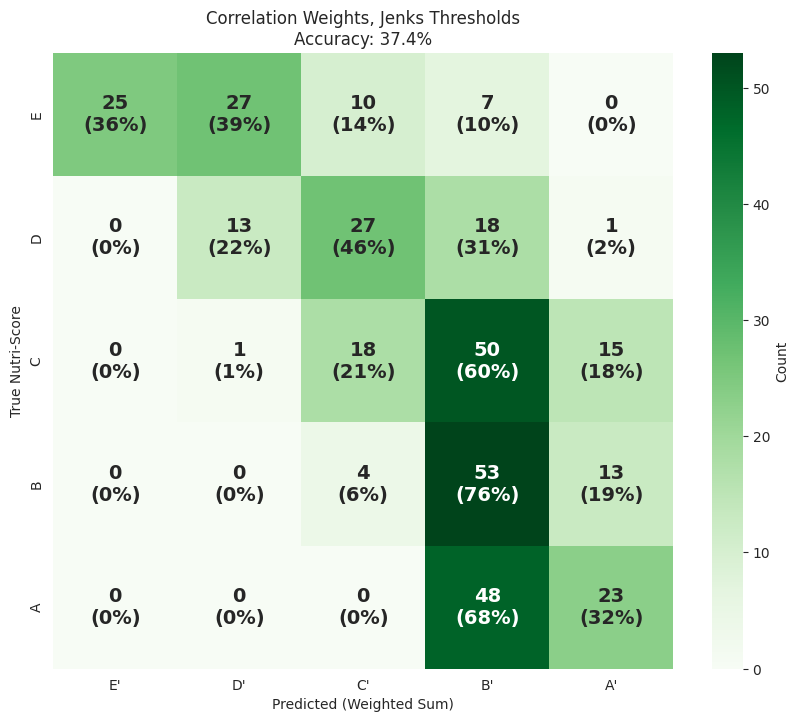


Classification Report:
              precision    recall  f1-score   support

           E       1.00      0.36      0.53        69
           D       0.32      0.22      0.26        59
           C       0.31      0.21      0.25        84
           B       0.30      0.76      0.43        70
           A       0.44      0.32      0.37        71

    accuracy                           0.37       353
   macro avg       0.47      0.38      0.37       353
weighted avg       0.47      0.37      0.37       353



In [34]:
weighted_sum_confusion_analysis(
    df, 
    experiment_name="Correlation Weights, Jenks Thresholds",
    weights=all_weights['Correlation'],
    thresholds=get_statistical_thresholds(
        df, all_weights['Correlation'],
        method='jenks'))

### TRIAL FOR MANUAL SETTING OF LIMITS AND UTILITY FUNCTIONS

Calculating grades...

OVERALL ACCURACY: 26.35%
WEIGHTED F1 SCORE: 0.17

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           A       0.00      0.00      0.00        71
           B       0.33      0.93      0.48        70
           C       0.22      0.30      0.25        84
           D       0.05      0.03      0.04        59
           E       1.00      0.01      0.03        69

    accuracy                           0.26       353
   macro avg       0.32      0.25      0.16       353
weighted avg       0.32      0.26      0.17       353



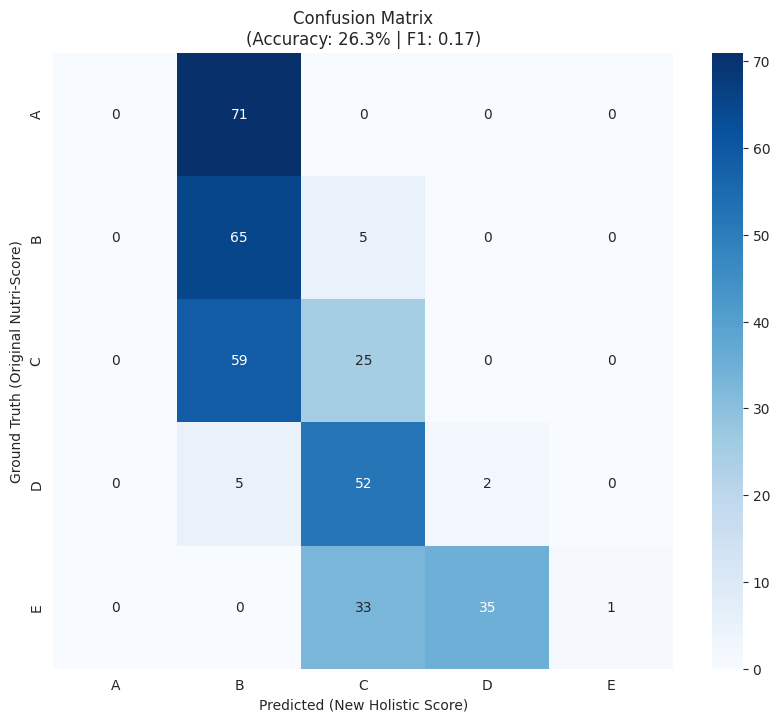

In [35]:
def generate_full_evaluation(df):
    """
    1. Calculates dynamic limits (ignoring text columns).
    2. Computes the New Holistic Grade.
    3. Prints Classification Report, Accuracy, and F1.
    4. Plots Confusion Matrix.
    """
    

    numeric_stats = df.select_dtypes(include=[np.number]).quantile(0.95)
    
    limits = {
        'energy': max(numeric_stats.get('energy_100g', 3350), 100),
        'sat_fat': max(numeric_stats.get('saturated_fat_100g', 10), 1),
        'sugar': max(numeric_stats.get('sugars_100g', 50), 1),
        'salt': max(numeric_stats.get('salt_100g', 2.5), 0.1),
        'protein': max(numeric_stats.get('proteins_100g', 8), 1),
        'fiber': max(numeric_stats.get('fiber_100g', 8), 1),
        'fvl': 100.0, 
        'green': 100.0
    }
    
    # --- 2. GRADING LOGIC ---
    def get_grade(row):
        # Negatives (Inverted 1->0)
        u_energy  = max(0, 1 - (row['energy_100g'] / limits['energy']))
        u_sat_fat = max(0, 1 - (row['saturated_fat_100g'] / limits['sat_fat']))
        u_sugar   = max(0, 1 - (row['sugars_100g'] / limits['sugar']))
        u_salt    = max(0, 1 - (row['salt_100g'] / limits['salt']))
        
        # Positives (Capped 0->1)
        u_protein = min(1, row['proteins_100g'] / limits['protein'])
        u_fiber   = min(1, row['fiber_100g'] / limits['fiber'])
        u_fvl     = min(1, row['fvl_percent'] / limits['fvl'])
        u_green   = min(1, row['green_score_value'] / limits['green'])
        
        # Weights (60% Positive / 40% Negative)
        w_neg = 0.10
        w_macro = 0.10
        w_hero = 0.20
        w_good = 0.15
        w_low = 0.05

        # score = (
        #     (u_energy * w_neg) + (u_sat_fat * w_hero) + (u_sugar * w_good) + (u_salt * w_neg) +
        #     (u_protein * w_macro) + (u_fiber * w_macro) +
        #     (u_fvl * w_hero) + (u_green * w_low)
        # )

        score = (
            (u_energy * 0.1405) + (u_sat_fat * 0.1470) + (u_sugar * 0.1789) + (u_salt * 0.1715) +
            (u_protein * 0.1038) + (u_fiber * 0.1030) +
            (u_fvl * 0.0806) + (u_green * 0.0747)
        )
        
        if score >= 0.80: return 'A'
        elif score >= 0.60: return 'B'
        elif score >= 0.40: return 'C'
        elif score >= 0.20: return 'D'
        else: return 'E'

    # Apply grading
    print("Calculating grades...")
    df['new_grade'] = df.apply(get_grade, axis=1)
    
    # --- 3. EVALUATION METRICS ---
    # Prepare data for sklearn
    # Ensure labels are uppercase and consistent
    df['nutri_score_label'] = df['nutri_score_label'].astype(str).str.upper()
    valid_labels = ['A', 'B', 'C', 'D', 'E']
    
    # Filter only rows where valid grades exist in both columns
    mask = df['nutri_score_label'].isin(valid_labels) & df['new_grade'].isin(valid_labels)
    y_true = df.loc[mask, 'nutri_score_label']
    y_pred = df.loc[mask, 'new_grade']
    
    # Calculate Metrics
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted') # Weighted accounts for class imbalance
    report = classification_report(y_true, y_pred, labels=valid_labels, zero_division=0)
    cm = confusion_matrix(y_true, y_pred, labels=valid_labels)
    
    # Print Text Report
    print("\n" + "="*60)
    print(f"OVERALL ACCURACY: {acc:.2%}")
    print(f"WEIGHTED F1 SCORE: {f1:.2f}")
    print("="*60)
    print("\nCLASSIFICATION REPORT:")
    print(report)
    
    # --- 4. VISUALIZATION ---
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=valid_labels, yticklabels=valid_labels)
    plt.title(f'Confusion Matrix\n(Accuracy: {acc:.1%} | F1: {f1:.2f})')
    plt.xlabel('Predicted (New Holistic Score)')
    plt.ylabel('Ground Truth (Original Nutri-Score)')
    plt.show()
    
    return df

# Usage:
df_result = generate_full_evaluation(df)

### MANUAL SETTINGS


EXPERIMENT: Equal Weights, Equal Thresholds
Weights Used: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']
Overall Accuracy:   22.1% (78/353)


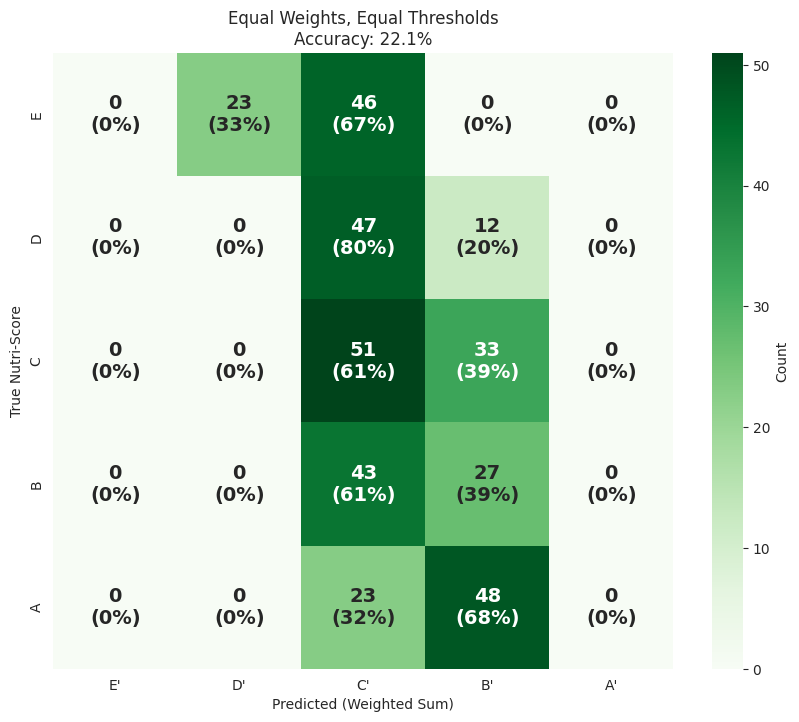


Classification Report:
              precision    recall  f1-score   support

           E       0.00      0.00      0.00        69
           D       0.00      0.00      0.00        59
           C       0.24      0.61      0.35        84
           B       0.23      0.39      0.28        70
           A       0.00      0.00      0.00        71

    accuracy                           0.22       353
   macro avg       0.09      0.20      0.13       353
weighted avg       0.10      0.22      0.14       353



In [36]:
weighted_sum_confusion_analysis(
    df, 
    experiment_name="Equal Weights, Equal Thresholds",
    weights=weights_equal,
    thresholds=[0.2, 0.4, 0.6, 0.8])

✓ Quantile-based thresholds: ['0.495', '0.554', '0.590', '0.630']

EXPERIMENT: Equal Weights, Quantile Thresholds
Weights Used: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']
Overall Accuracy:   42.2% (149/353)


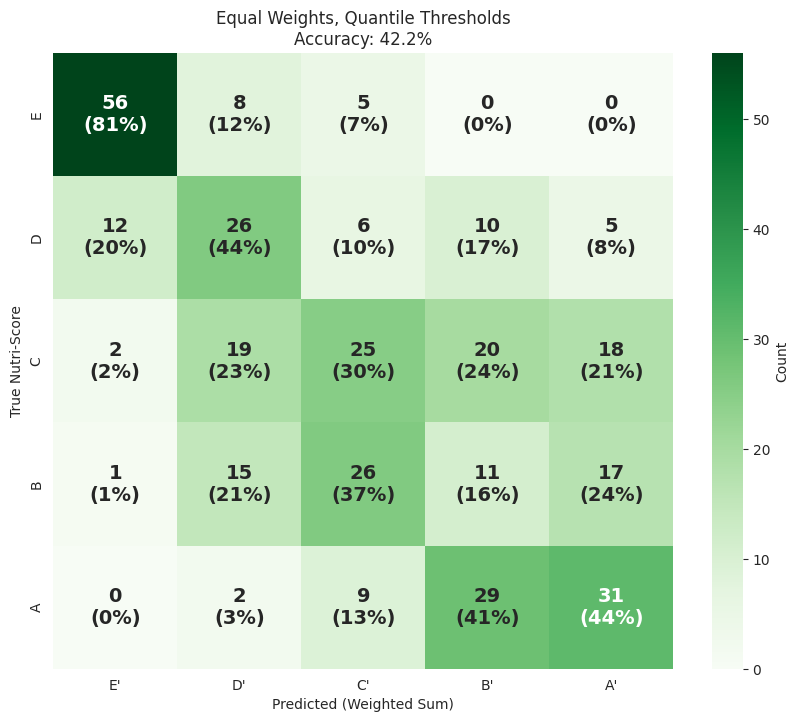


Classification Report:
              precision    recall  f1-score   support

           E       0.79      0.81      0.80        69
           D       0.37      0.44      0.40        59
           C       0.35      0.30      0.32        84
           B       0.16      0.16      0.16        70
           A       0.44      0.44      0.44        71

    accuracy                           0.42       353
   macro avg       0.42      0.43      0.42       353
weighted avg       0.42      0.42      0.42       353



In [37]:
weighted_sum_confusion_analysis(
    df, 
    experiment_name="Equal Weights, Quantile Thresholds",
    weights=weights_equal,
    thresholds=get_statistical_thresholds(
        df, weights_equal,
        method='quantile'))

✓ GMM-based thresholds: ['0.432', '0.522', '0.590', '0.663']

EXPERIMENT: Equal Weights, GMM Thresholds
Weights Used: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']
Overall Accuracy:   37.7% (133/353)


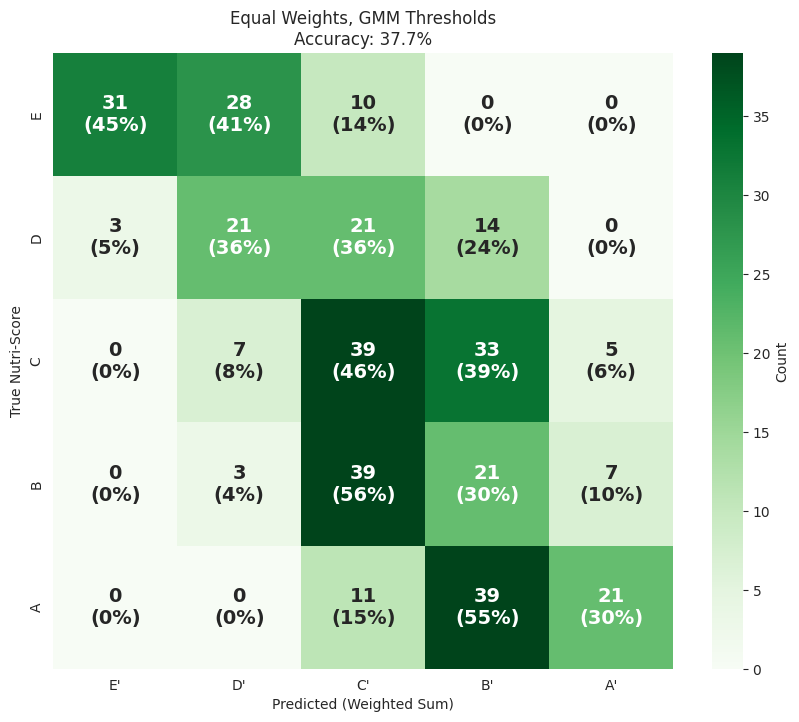


Classification Report:
              precision    recall  f1-score   support

           E       0.91      0.45      0.60        69
           D       0.36      0.36      0.36        59
           C       0.33      0.46      0.38        84
           B       0.20      0.30      0.24        70
           A       0.64      0.30      0.40        71

    accuracy                           0.38       353
   macro avg       0.49      0.37      0.40       353
weighted avg       0.48      0.38      0.40       353



In [43]:
weighted_sum_confusion_analysis(
    df, 
    experiment_name="Equal Weights, GMM Thresholds",
    weights=weights_equal,
    thresholds=get_statistical_thresholds(
        df, weights_equal,
        method='gmm'))

✓ K-means based thresholds: ['0.427', '0.521', '0.591', '0.665']

EXPERIMENT: Equal Weights, Kmeans Thresholds
Weights Used: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']
Overall Accuracy:   37.1% (131/353)


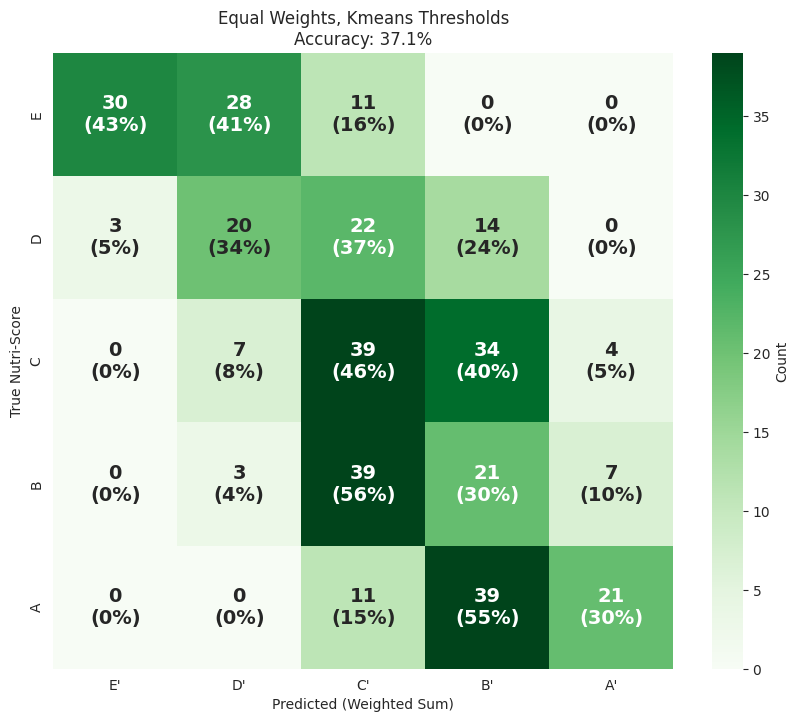


Classification Report:
              precision    recall  f1-score   support

           E       0.91      0.43      0.59        69
           D       0.34      0.34      0.34        59
           C       0.32      0.46      0.38        84
           B       0.19      0.30      0.24        70
           A       0.66      0.30      0.41        71

    accuracy                           0.37       353
   macro avg       0.48      0.37      0.39       353
weighted avg       0.48      0.37      0.39       353



In [44]:
weighted_sum_confusion_analysis(
    df, 
    experiment_name="Equal Weights, Kmeans Thresholds",
    weights=weights_equal,
    thresholds=get_statistical_thresholds(
        df, weights_equal,
        method='kmeans'))

✓ Jenks Natural Breaks thresholds: ['0.424', '0.516', '0.590', '0.664']

EXPERIMENT: Equal Weights, Jenks Thresholds
Weights Used: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']
Overall Accuracy:   36.8% (130/353)


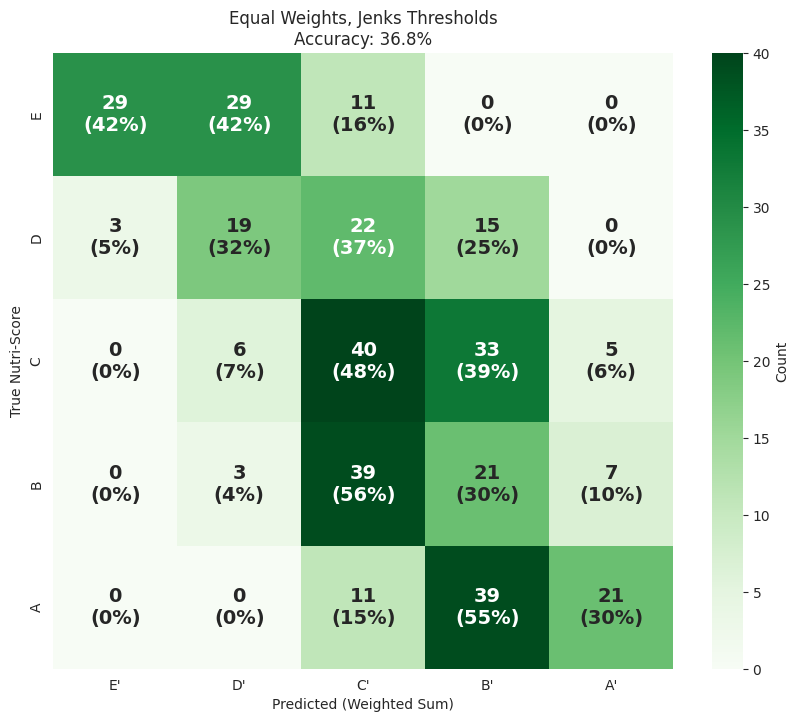


Classification Report:
              precision    recall  f1-score   support

           E       0.91      0.42      0.57        69
           D       0.33      0.32      0.33        59
           C       0.33      0.48      0.39        84
           B       0.19      0.30      0.24        70
           A       0.64      0.30      0.40        71

    accuracy                           0.37       353
   macro avg       0.48      0.36      0.39       353
weighted avg       0.48      0.37      0.39       353



In [45]:
weighted_sum_confusion_analysis(
    df, 
    experiment_name="Equal Weights, Jenks Thresholds",
    weights=weights_equal,
    thresholds=get_statistical_thresholds(
        df, weights_equal,
        method='jenks'))

✓ Quantile-based thresholds: ['0.587', '0.637', '0.697', '0.739']

EXPERIMENT: Negative Emphasis Weights, Quantile Thresholds
Weights Used: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']
Overall Accuracy:   38.5% (136/353)


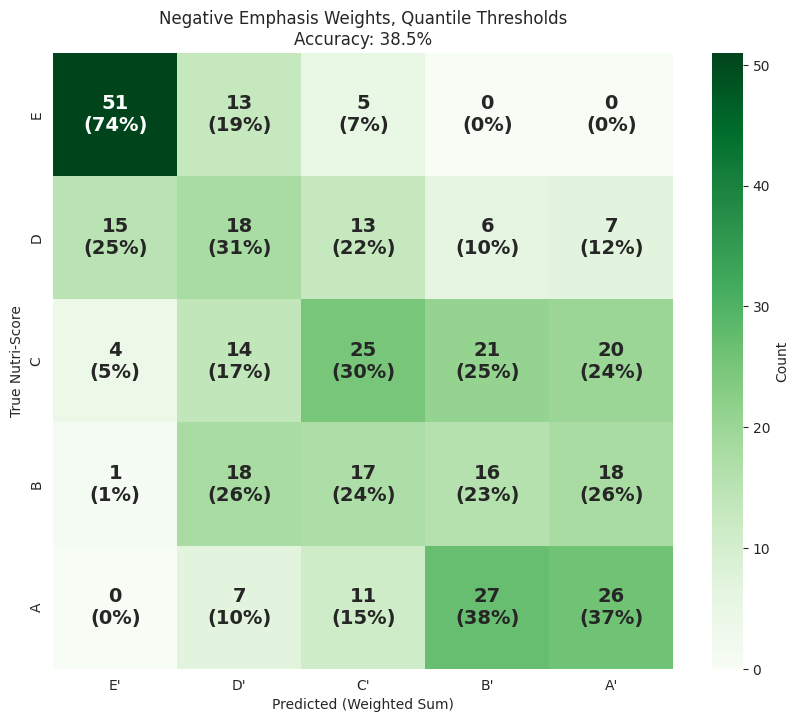


Classification Report:
              precision    recall  f1-score   support

           E       0.72      0.74      0.73        69
           D       0.26      0.31      0.28        59
           C       0.35      0.30      0.32        84
           B       0.23      0.23      0.23        70
           A       0.37      0.37      0.37        71

    accuracy                           0.39       353
   macro avg       0.38      0.39      0.38       353
weighted avg       0.39      0.39      0.38       353



In [38]:
weighted_sum_confusion_analysis(
    df, 
    experiment_name="Negative Emphasis Weights, Quantile Thresholds",
    weights=weights_emphasis_negative,
    thresholds=get_statistical_thresholds(
        df, weights_emphasis_negative,
        method='quantile'))

✓ Quantile-based thresholds: ['0.454', '0.517', '0.581', '0.635']

EXPERIMENT: Balanced Weights, Quantile Thresholds
Weights Used: ['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'salt_100g', 'proteins_100g', 'fiber_100g', 'fvl_percent', 'green_score_value']
Overall Accuracy:   32.3% (114/353)


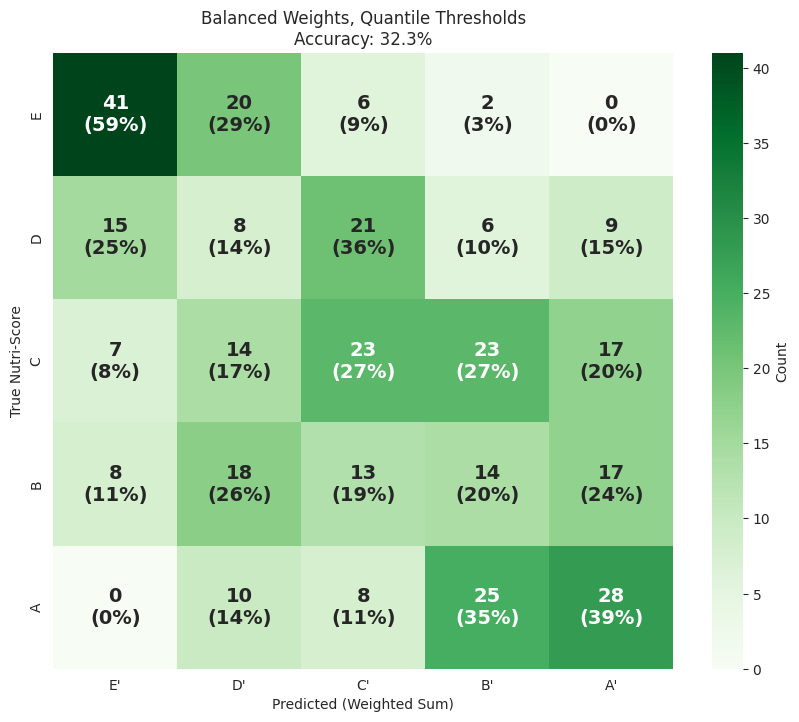


Classification Report:
              precision    recall  f1-score   support

           E       0.58      0.59      0.59        69
           D       0.11      0.14      0.12        59
           C       0.32      0.27      0.30        84
           B       0.20      0.20      0.20        70
           A       0.39      0.39      0.39        71

    accuracy                           0.32       353
   macro avg       0.32      0.32      0.32       353
weighted avg       0.33      0.32      0.32       353



In [39]:
weighted_sum_confusion_analysis(
    df, 
    experiment_name="Balanced Weights, Quantile Thresholds",
    weights=weights_balanced,
    thresholds=get_statistical_thresholds(
        df, weights_balanced,
        method='quantile'))